# Import  libraries

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #plotting a confusion matrix

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

TEST_SIZE = 0.20 # test size using_train_test_split

NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# Read data

In [63]:
df=pd.read_csv('creditcard.csv')

In [47]:
df.shape[0],df.shape[1]

(284807, 31)

# Glimpse data

In [48]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [49]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Check missing values

In [51]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# Check imbalance

Text(0.5, 1.0, 'Count of Fraud and Not Fraud Class')

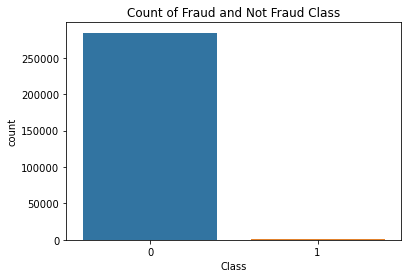

In [52]:
sns.countplot(df['Class'])
plt.title('Count of Fraud and Not Fraud Class')

<AxesSubplot:title={'center':'Credit Card Status'}, ylabel='Class'>

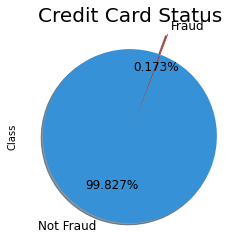

In [53]:
labels ="Not Fraud", "Fraud"
colors = ["#3791D7", "#D72626"]

plt.title('Credit Card Status', fontsize=20)

df["Class"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.3f%%', shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)

# Data Analysis with plots

In [57]:
fraud= df[df['Class']==1]['Time']
not_fraud= df[df['Class']==0]['Time']

cats = ['Fraud', 'Not Fraud']

hist_data= [fraud, not_fraud]

figure = ff.create_distplot(hist_data, cats,show_hist=False,show_rug=False)

figure['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(figure)

In [64]:
df['Hour']=df['Time'].apply(lambda x: np.floor(x/3600))

temp2 = df.groupby(['Hour','Class'])['Amount'].agg(['min','max','count','sum','mean','median','var']).reset_index()

temp2.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
temp2.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


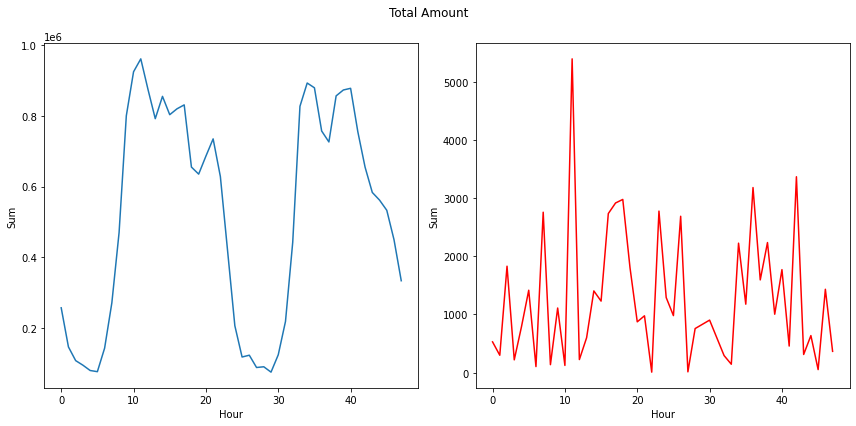

In [83]:
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(12,6))

plt.suptitle('Total Amount')
sns.lineplot(ax=ax1, y='Sum', x= 'Hour', data= temp2.loc[temp2.Class==0])
sns.lineplot(ax=ax2, y='Sum', x= 'Hour', data= temp2.loc[temp2.Class==1],color='red')
plt.tight_layout()
plt.show()

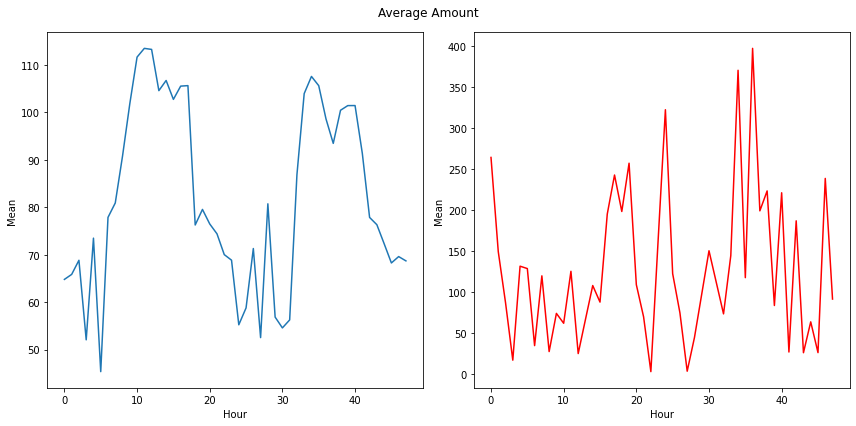

In [97]:
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(12,6))

plt.suptitle('Average Amount')
sns.lineplot(ax=ax1, y='Mean', x= 'Hour', data= temp2.loc[temp2.Class==0])
sns.lineplot(ax=ax2, y='Mean', x= 'Hour', data= temp2.loc[temp2.Class==1],color='red')
plt.tight_layout()
plt.show()

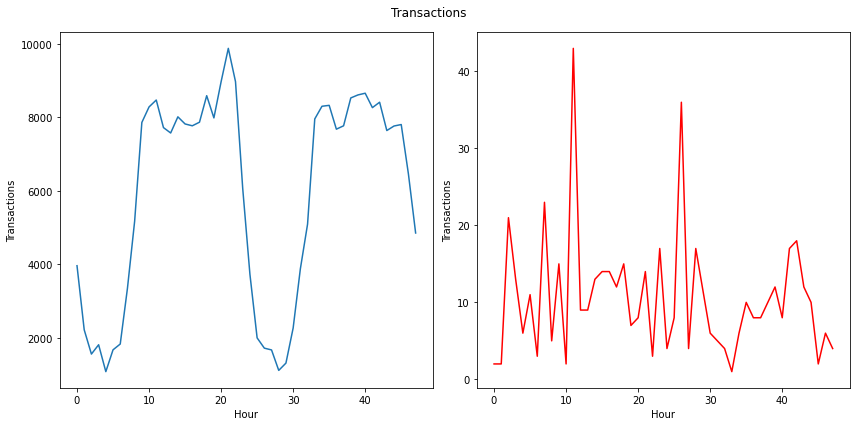

In [85]:
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(12,6))

plt.suptitle('Transactions')
sns.lineplot(ax=ax1, y='Transactions', x= 'Hour', data= temp2.loc[temp2.Class==0])
sns.lineplot(ax=ax2, y='Transactions', x= 'Hour', data= temp2.loc[temp2.Class==1],color='red')
plt.tight_layout()
plt.show()

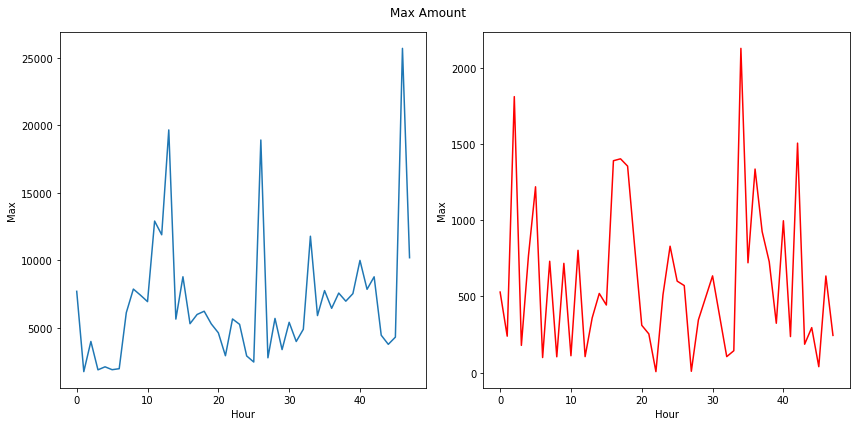

In [88]:
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(12,6))

plt.suptitle('Max Amount')
sns.lineplot(ax=ax1, y='Max', x= 'Hour', data= temp2.loc[temp2.Class==0])
sns.lineplot(ax=ax2, y='Max', x= 'Hour', data= temp2.loc[temp2.Class==1],color='red')
plt.tight_layout()
plt.show()

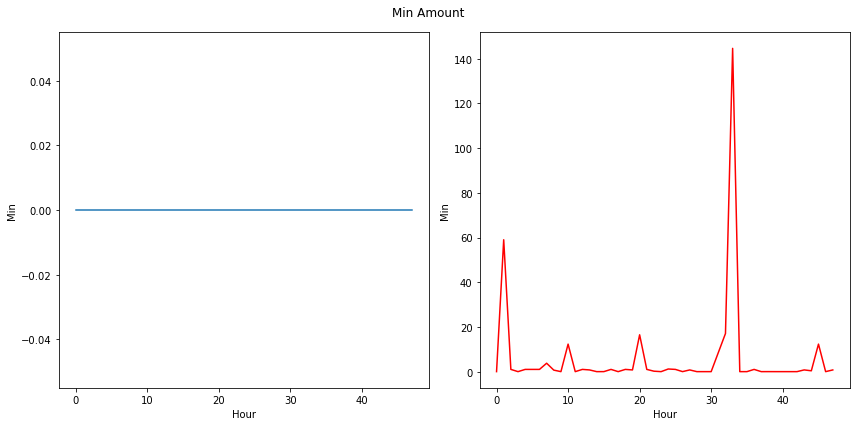

In [89]:
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(12,6))

plt.suptitle('Min Amount')
sns.lineplot(ax=ax1, y='Min', x= 'Hour', data= temp2.loc[temp2.Class==0])
sns.lineplot(ax=ax2, y='Min', x= 'Hour', data= temp2.loc[temp2.Class==1],color='red')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Class', ylabel='Amount'>

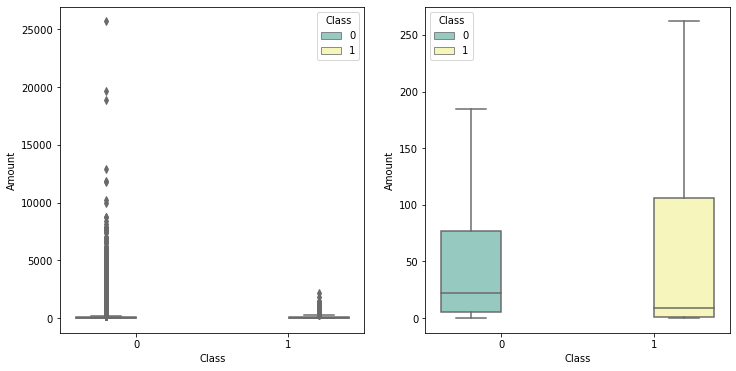

In [96]:
fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(12,6))

#With Outliers
sns.boxplot(ax=ax1, x= df['Class'],y = df['Amount'], hue=df['Class'],showfliers=True,palette= 'Set3')

#Without Outliers
sns.boxplot(ax=ax2, x= df['Class'],y = df['Amount'], hue=df['Class'],showfliers=False, palette= 'Set3')

In [98]:
class_0 = df[df['Class']==0]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [101]:
class_1 = df[df['Class']==1]['Amount']
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

# Correlation

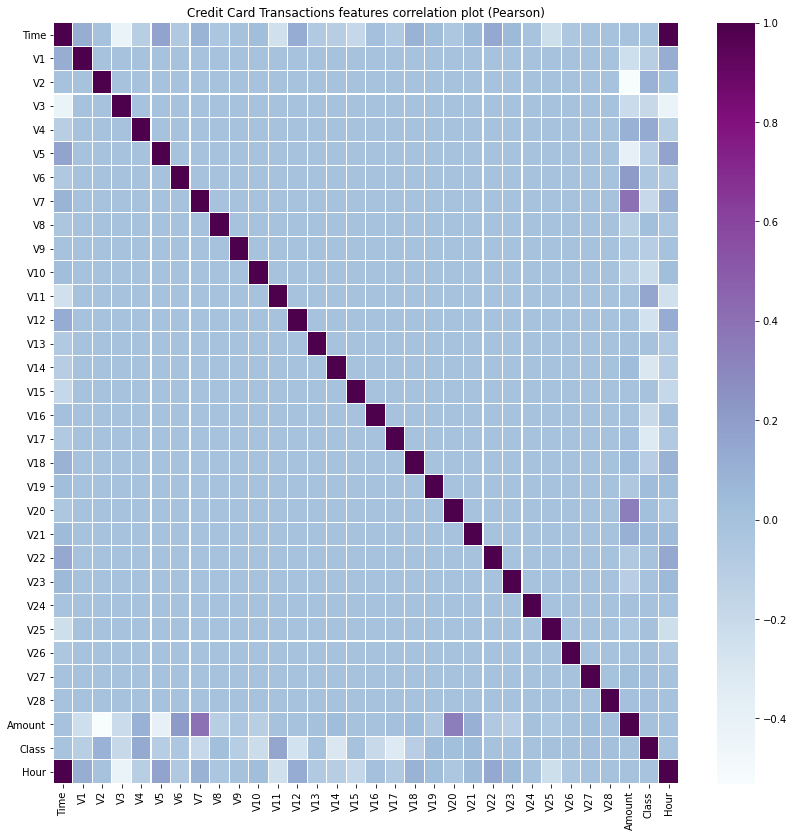

In [105]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr, cmap="BuPu",linewidths=.1)
plt.show()

The correlation matrix shows that there is no strong correlation between variables. However, V7 and V20 features have certain direct correlation with Amount. V2 and V5 have inverse correlation with Amount.

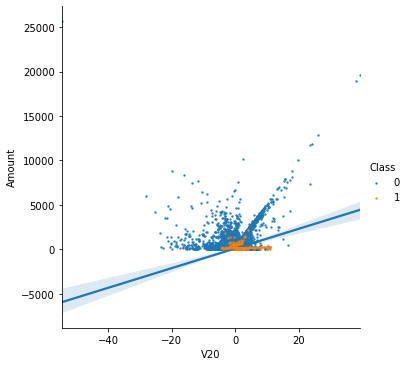

In [107]:
sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})

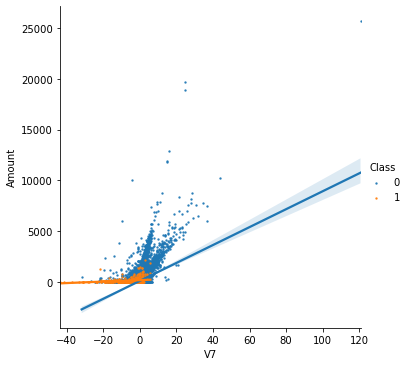

In [112]:
sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})

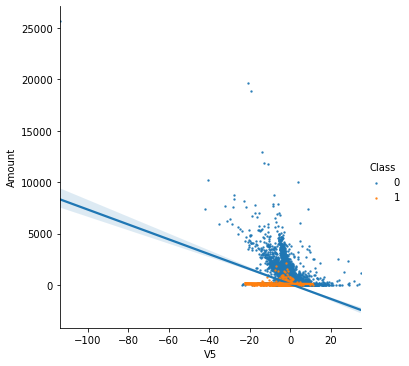

In [114]:
sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})

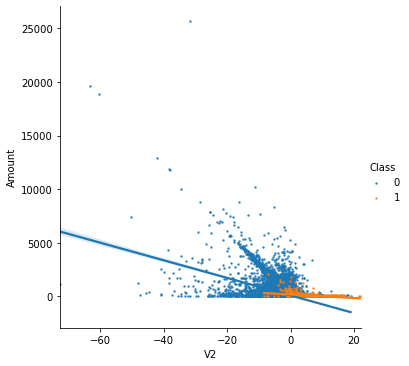

In [115]:
sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})

# Train_Test Splitting

In [117]:
X = df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']]

y = df['Class']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size= 0.2, random_state = 101, shuffle = True)

### RandomForestClassifier

In [166]:
clf_rc = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=True)

In [167]:
clf_rc.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   55.1s finished


RandomForestClassifier(n_jobs=4, random_state=2018, verbose=True)

In [168]:
preds_rc = clf_rc.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


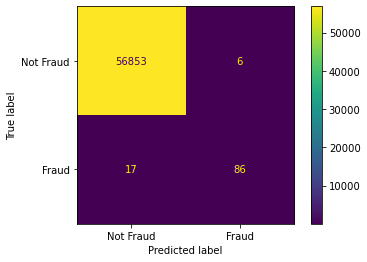

In [169]:
plot_confusion_matrix(clf_rc,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Not Fraud','Fraud'])

In [177]:
roc_auc_score(y_test, preds_rc)

0.9174229660596295

## AdaBoostClassifier

In [148]:
clf_ada = AdaBoostClassifier(learning_rate= 0.5,
                            random_state=101,
                             algorithm= "SAMME.R",
                             n_estimators=NUM_ESTIMATORS)

In [149]:
clf_ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=101)

In [163]:
preds_ada = clf_ada.predict(X_test)

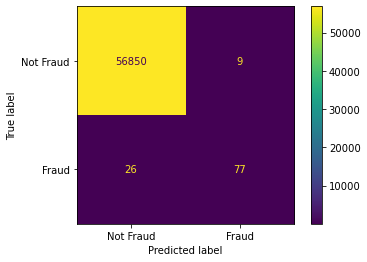

In [164]:
plot_confusion_matrix(clf_ada,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Not Fraud','Fraud'])

In [176]:
roc_auc_score(y_test, preds_ada)

0.8737072646234246

## XGBoostClassifier

In [171]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',missing=0,seed=42)
clf_xgb.fit(X_train, y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.79962
[1]	validation_0-aucpr:0.82712
[2]	validation_0-aucpr:0.83089
[3]	validation_0-aucpr:0.83325
[4]	validation_0-aucpr:0.83074
[5]	validation_0-aucpr:0.83174
[6]	validation_0-aucpr:0.83427
[7]	validation_0-aucpr:0.83418
[8]	validation_0-aucpr:0.83725
[9]	validation_0-aucpr:0.83698
[10]	validation_0-aucpr:0.84670
[11]	validation_0-aucpr:0.85606
[12]	validation_0-aucpr:0.85939
[13]	validation_0-aucpr:0.85821
[14]	validation_0-aucpr:0.85949
[15]	validation_0-aucpr:0.86125
[16]	validation_0-aucpr:0.85926
[17]	validation_0-aucpr:0.85907
[18]	validation_0-aucpr:0.85925
[19]	validation_0-aucpr:0.85823
[20]	validation_0-aucpr:0.85889
[21]	validation_0-aucpr:0.86027
[22]	validation_0-aucpr:0.85924
[23]	validation_0-aucpr:0.85842
[24]	validation_0-aucpr:0.85893


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=0, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [180]:
preds_xgb = clf_xgb.predict(X_test)

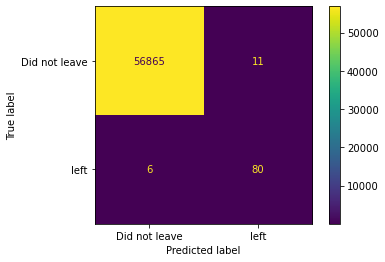

In [181]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     preds,
                     values_format='d',
                     display_labels=['Did not leave','left'])

In [183]:
roc_auc_score(y_test, preds_xgb)

0.9125685971275906

## CatBoostClassifier

In [184]:
clf_cat = CatBoostClassifier(iterations=500,
                             learning_rate=0.5,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 101,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [185]:
clf_cat.fit(X_train, y_train)

0:	total: 664ms	remaining: 5m 31s
50:	total: 22.9s	remaining: 3m 21s
100:	total: 45.2s	remaining: 2m 58s
150:	total: 1m 6s	remaining: 2m 34s
200:	total: 1m 28s	remaining: 2m 11s
250:	total: 1m 50s	remaining: 1m 49s
300:	total: 2m 10s	remaining: 1m 26s
350:	total: 2m 31s	remaining: 1m 4s
400:	total: 2m 51s	remaining: 42.3s
450:	total: 3m 8s	remaining: 20.5s
499:	total: 3m 24s	remaining: 0us


In [186]:
preds_cat = clf_cat.predict(X_test)

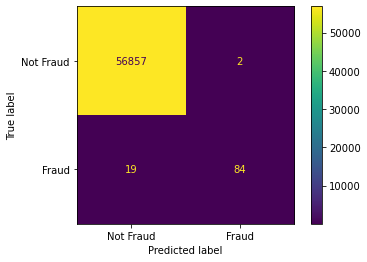

In [187]:
plot_confusion_matrix(clf_cat,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Not Fraud','Fraud'])

In [189]:
roc_auc_score(y_test,preds_cat)

0.9077494029260254